In [1]:
import time
import numpy as np
import pandas as pd
import ringity as rng
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from collections import defaultdict
from ringity.generators.utils.param_utils import rate_to_beta, beta_to_rate

## Model parameters

In [2]:
N = 2**9

config_dict = {
    
# MADE IT TO FIGURE
    'default' : {
        'c' : 1,
        'r' : 0.25,
        'beta' : 1,
        'rho' : None,
    },
    'longerResponse' : {
        'c' : 1,
        'r' : 0.375,
        'beta' : 1,
        'rho' : None,
    },
    'weakerInteraction' : {
        'c' : 0.1,
        'r' : 0.25,
        'beta' : 1,
        'rho' : None,
    },
    'shorterDelay' : {
        'c' : 1,
        'r' : 0.25,
        'beta' : 0.75,
        'rho' : None,
    },
    'constantDensity' : {
        'c' : None,
        'r' : 0.375,
        'beta' : 1,
        'rho' : 0.025,
    },
    'shorterResponse' : {
        'c' : 1,
        'r' : 0.125,
        'beta' : 1,
        'rho' : None,
    },
    'evenLongerResponse' : {
        'c' : 1,
        'r' : 0.75,
        'beta' : 1,
        'rho' : None,
    },
    'evenShorterDelay' : {
        'c' : 1,
        'r' : 0.25,
        'beta' : 0.5,
        'rho' : None,
    },
    'random' : {
        'c' : np.random.uniform(),
        'r' : np.random.uniform(),
        'beta' : np.random.uniform(),
        'rho' : None,
    },
    'random_rho' : {
        'c' : np.random.uniform(),
        'r' : None,
        'beta' : np.random.uniform(),
        'rho' : np.random.uniform(),
    }
}

## Default model

In [3]:
configuration = 'default'

In [4]:
G, pos, builder = rng.network_model(
                                N = N,
                                return_positions = True, 
                                return_builder = True,
                                verbose = True,
                                **config_dict[configuration])

Response parameter was set  to: r = 0.25
Rate parameter was set to:   rate = 0.0
Coupling parameter was set to:  c = 1
Density parameter was set to: rho = 0.25
Uniform (beta = 1) model detected.


In [5]:
rho_obs = nx.density(G)
rho_exp = builder.density
score = rng.ring_score(G)

In [6]:
print(f"rho_obs = {rho_obs:.3f}")
print(f"rho_exp = {rho_exp:.3f}")
print(f"score   = {score:.3f}")

rho_obs = 0.248
rho_exp = 0.250
score   = 0.989


In [7]:
circ_layout = {n:(np.cos(t), np.sin(t)) for n,t in enumerate(pos)}
spring_layout = nx.spring_layout(G)

In [8]:
c = builder.coupling
r = builder.response
rho = builder.density
beta = rate_to_beta(builder.rate)

## Interaction function

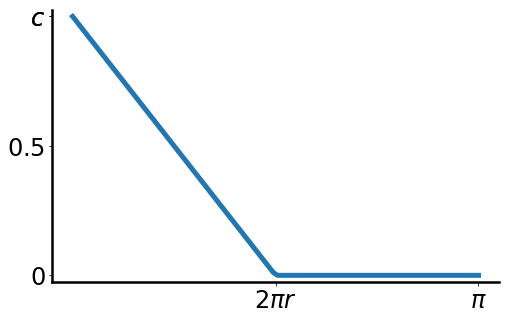

In [9]:
x = np.linspace(0, np.pi, 100)
y = c*(1-x/(2*np.pi*r)).clip(0)

fig_func, ax = plt.subplots(figsize = (8,5))

ax.plot(x, y, linewidth = 5)


plt.xticks([2*np.pi*r, np.pi], [r'$2\pi r$', r'$\pi$'])
plt.yticks([0, 0.5, 1, c], [r'$0$', r'$0.5$', r'$1$', r'$c$'])

ax.set_ylim(-0.025, 1.025)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

rng.ax_setup(ax)

## Network visualization

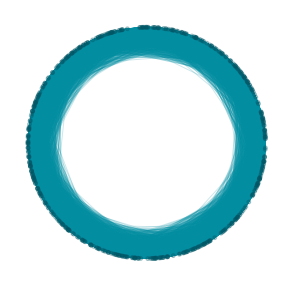

In [10]:
netviz_circ_fig, ax = plt.subplots(figsize = (5,5))

ax.set_xlim(-1.175,1.175)
ax.set_ylim(-1.175,1.175)

rng.plot_nx(G, ax=ax, pos = circ_layout)

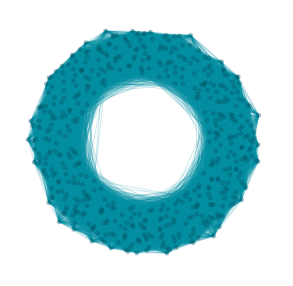

In [11]:
netviz_spri_fig, ax = plt.subplots(figsize = (5,5))

ax.set_xlim(-1.175,1.175)
ax.set_ylim(-1.175,1.175)

rng.plot_nx(G, ax=ax, pos = spring_layout)

## ring-score distribution

In [20]:
n_ensemble = 2**1
N = builder.N
r_list = np.linspace(rho, 1, 5)

In [21]:
score = defaultdict(list)

t1 = time.time()
for r in r_list:
    print(r)
    for _ in range(n_ensemble):
        G = rng.network_model(N=N, rho=rho, r=r, beta=beta)
        score[r].append(rng.ring_score(G))
        
t2 = time.time()

print(t2 - t1)

0.25
0.4375
0.625
0.8125
1.0
30.42710018157959


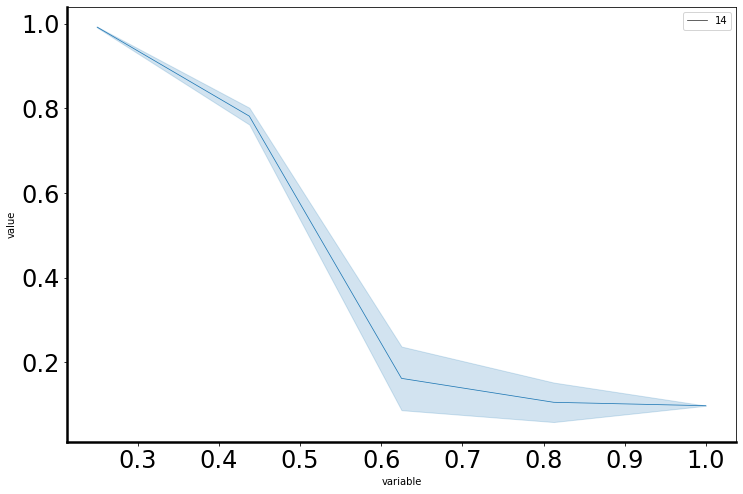

In [22]:
plot_df = pd.melt(pd.DataFrame(score))

fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(x = "variable", y = "value", data = plot_df, ax=ax, size=14)
rng.ax_setup(ax)
plt.savefig("/Users/markusyoussef/Desktop/test.png")

In [27]:
n_ensemble = 2**4
N_list = [2**k for k in range(5, 9)]
r = builder.response
score = defaultdict(list)

t1 = time.time()
for N in N_list:
    print(N)
    for _ in range(n_ensemble):
        G = rng.network_model(N=N, c=c, r=r, beta=beta)
        score[N].append(rng.ring_score(G))
        
t2 = time.time()

print(t2 - t1)

19.147202968597412


In [28]:
plot_df = pd.melt(pd.DataFrame(score))

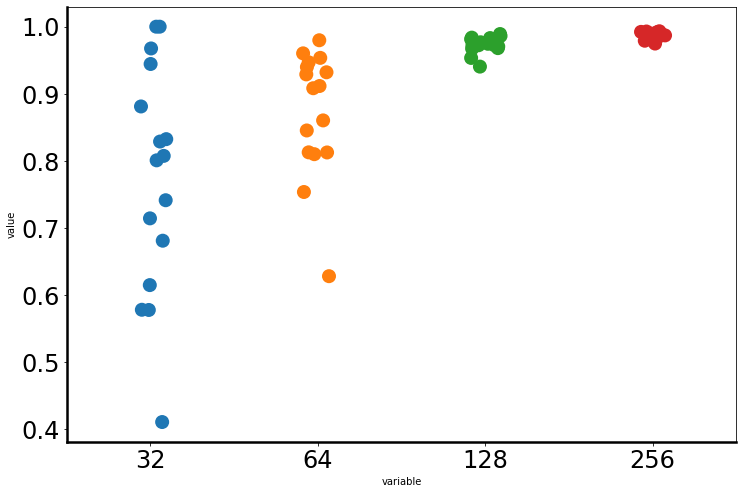

In [29]:
fig, ax = plt.subplots(figsize = (12,8))
sns.stripplot(x = "variable", y = "value", data = plot_df, ax=ax, size=14)
rng.ax_setup(ax)
plt.savefig("/Users/markusyoussef/Desktop/test.png")

## Clustering coefficient

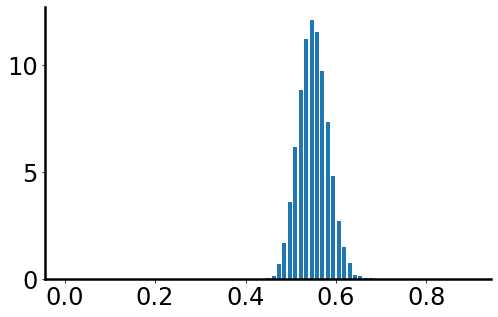

In [32]:
clust = []

for _ in range(2**6):
    G = rng.network_model(N=N, **config_dict[configuration])
    clust.extend(rng.clustering_coefficient(G))

clust_fig, ax = plt.subplots(figsize = (8,5))

ax.hist(clust, 
        bins=75, range=(0, 0.9), 
        rwidth = 0.75, density = True);

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

rng.ax_setup(ax)

## Degree distribution

In [33]:
def expected_conditional_similarity(theta, rate, a):
    if np.isclose(rate, 0, atol=1e-7):
        return a
    
    if np.isclose(rate, np.inf):
        A = 1/(2*np.pi*a)
        B = A*np.pi
        C = B - 1
        return np.clip(np.abs(A*theta - B) - C, 0, 1)
    
    if theta < np.pi:
        if theta <= 2*np.pi*a:
            norm = 1 / (1 - np.exp(-2*np.pi*rate)) / (2*a*np.pi*rate)
            
            theta_term = -theta*rate * (1 - np.exp(-2*np.pi*rate))
            
            term1  = -2*np.exp(-rate*theta) + 1
            term21 =  np.exp(-rate*theta)*(np.exp(-2*a*np.pi*rate) + np.exp((2*a*np.pi - 2*np.pi)*rate))
            term22 = -np.exp(-2*np.pi*rate)
            
            return norm*(term1 + term21 + term22 + theta_term) + 1
        else:
            theta_term = np.exp(-rate*theta) / (1 - np.exp(-2*np.pi*rate))
            alpha_term = (np.cosh(-rate*2*np.pi*a) - 1) / (a*np.pi*rate)
            return theta_term * alpha_term
        
    else:
        norm = 2*rate*np.exp(-rate*theta) / (1 - np.exp(-2*np.pi*rate))
        
        def undef_int(t):
            return (np.exp(np.pi*rate)*(np.cosh((np.pi - t)*rate) + (-2*a*np.pi + t)*rate*np.sinh((np.pi - t)*rate)))/(2*a*np.pi*rate**2)
        
        if 2*np.pi - theta <= 2*np.pi*a:
            term1 = (-1 + np.cosh((2*np.pi - theta)*rate) + (2*(-1 + a)*np.pi + theta)*rate*np.sinh((2*np.pi - theta)*rate))/(2*a*np.pi*rate**2)
            term2 = undef_int(2*np.pi*a) - undef_int(2*np.pi - theta)
            return norm*term1 + norm*term2
        else:
            return norm*(np.sinh(a*np.pi*rate)**2)/(a*np.pi*rate**2)

In [35]:
c = builder.coupling
r = builder.response
rate = builder.rate

degs_exp = [p for theta in pos for p in np.random.binomial(N-1, c*expected_conditional_similarity(theta=theta, rate=rate, a=r), size=2**10)]

In [36]:
degs_exp, freqs_exp = zip(*Counter(degs_exp).items())
freqs_exp = np.array(freqs_exp) / sum(freqs_exp)

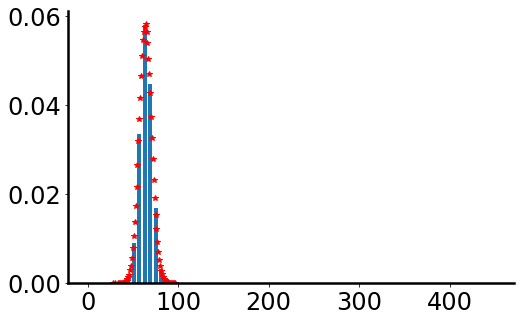

In [37]:
degs = []

for _ in range(2**6):
    G = rng.network_model(N=N, c=c, r=r, beta=beta)
    degs.extend([deg for n, deg in nx.degree(G)])

degs_obs, freqs_obs = zip(*Counter(degs).items())
freqs_obs = np.array(freqs_obs) / sum(freqs_obs)

deg_fig, ax = plt.subplots(figsize = (8,5))

ax.hist(degs, 
        bins = 75, range = (0, 450),
        rwidth = 0.75, density = True);

ax.plot(degs_exp, freqs_exp, '*r')


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#ax.set_xlabel('degree', fontsize=24)
#ax.set_ylabel('frequency', fontsize=18)

rng.ax_setup(ax)

## Save data

In [98]:
fig_dir = Path("/Users/markusyoussef/Desktop/fig3/")

fig_func.savefig(fig_dir / f"{configuration}_interactionFunction.png")
fig_func.savefig(fig_dir / f"{configuration}_interactionFunction.pdf")

#netviz_circ_fig.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_network_circular.png")
#netviz_circ_fig.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_network_circular.pdf")

netviz_spri_fig.savefig(fig_dir / f"{configuration}_network_spring.png")
netviz_spri_fig.savefig(fig_dir / f"{configuration}_network_spring.pdf")

clust_fig.savefig(fig_dir / f"{configuration}_clustering.png")
clust_fig.savefig(fig_dir / f"{configuration}_clustering.pdf")

deg_fig.savefig(fig_dir / f"{configuration}_degree.png")
deg_fig.savefig(fig_dir / f"{configuration}_degree.pdf")